# Authors

*The work can be done in groups of up to 3 students. Please complete the following fields with your group number and list your names along with HDI ID numbers.*

---
> **[HDU-???-24] Image Processing**
>
> 1. Name, HDU id
> 2. Name, HDU id
> 3. Name, HDU id
---

The task and guidelines were prepared by Andrei Zhdanov And Sergei Shavetov from ITMO University in 2024.

# Practical Assignment No 4. Images Morphological Analysis

Studying of the digital images morphological analysis main principles.

## Task 1. Basic morphological operations

*Select an arbitrary image containing shape defects (internal "holes" and external  "ledges"). Using basic morphological operations, completely remove or minimize defects.*

The term *morphology* literally translates as "the science of form" from Greek. Morphological analysis is used in many areas of knowledge, including image processing. It is a relatively universal approach, therefore it stands apart from all previously considered methods. Using mathematical morphology in image processing, it is possible to filter noise, segment objects, detect edges, implement a search for a given object in an image, calculate the image "skeleton", etc. Let's consider the image binary morphology basic operations $A$ by the structural element $B$:

 - Dilation (expansion): $C = A \oplus B$ dilates binary image $A$ by structural element $B$;
 - Erosion: $C = A \ominus B$ narrows down the binary image $A$ by structural element $B$;
 - Open: $C = (A \ominus B) \oplus B$ removes binary image external defects $A$ by structural element $B$;
 - Close: $C = (A \oplus B) \ominus B$ removes binary image internal defects $A$ by structural element $B$.

$\oplus$ and $\ominus$ operations which were used above are addition and subtraction of Minkowski, respectively.

| ![Morphological operations](images/morphology.png "The result of binary morphological operations") | 
|:--:| 
| *The result of binary morphological operations: a) binary image $A$, b) disk-shape structural element $B$, c) dilation, d) erosion, e) open, f) close.* |



**Morphological operations with OpenCV**

OpenCV provies following general functions to work with morphological operations:
 - `cv2.getStructuringElement(shape, size, anchor)` - define a structural element with given $shape$ and $size$. The morphologial element is defined with a binary matrix indicating the pixels which are affected by mask in relationship to the anchor point. If the $anchor$ point is not defined then it is placed at the center of kernel. The following default structuring elements are supported:
  - `cv2.MORPH_RECT` - a rectangular structuring element with given $size$;
  - `cv2.MORPH_CROSS` - a cross-shaped structuring element with given $size$;
  - `cv2.MORPH_ELLIPSE` - an elliptic structuring element inscribed into a rectangle with given $size$.
 - `cv::morphologyEx(A, op, B, anchor, iters, borderType, borderValue)` - apply a morphological filtering operation $op$ to an image $A$ with structural element $B$ $iters$ times. If the number of iterations is not defined, then it is defaulted to $1$. It also allows redefining the $anchor$ point value and function behavior near borders. In Python language the resulting image $C$ is a return value of a function. The possible morphological operations are:
  - `cv2.MORPH_ERODE` - perform the morphological erosion operation $C = A \ominus B$. `cv2.erode()` function can be used to do the same operation;
  - `cv2.MORPH_DILATE` - perform the morphological dilation operation $C = A \oplus B$. `cv2.dilate()` function can be used to do the same operation;
  - `cv2.MORPH_OPEN` - perform the morphological opening operation $C = (A \ominus B) \oplus B$. $open(A, B) = dilate(erode(A, B), B)$;
  - `cv2.MORPH_CLOSE` - perform the morphological closing operation $C = (A \oplus B) \ominus B$. $close(A, B) = erode(dilate(A, B), B)$.
  - `cv2.MORPH_GRADIENT` - perform the morphological gradient operation. This is the difference between dilation and erosion.  $gradient(A, B) = dilate(A, B)  - erode(A, B)$;
  - `cv2.MORPH_TOPHAT` - perform the morphological "top hat" operation. This is the difference between image and its opening. $tophat(A, B) = A - open(A, B)$;
  - `cv2.MORPH_BLACKHAT` - perform the morphological "black hat" operation. This is the difference between image closing and an image. $blackhat(A, B) = close(A, B)  - A$;
  - `cv2.MORPH_HITMISS` - perform the opening "hit \& miss" operation.

There are several more functions which are useful when working with morphology:
 - `retval, labels = cv2.connectedComponents(A)` function is used to list all connected components of the image $A$. It returns a tuple with the number of connected components and a matrix of component $labels$. Every image pixel is labeled with corresponding label and stored in the $labels$ matrix.
 - `retval, labels, stats, centroids = cv2.connectedComponentsWithStats(A)` function is similar with the above `connectedComponents()` one, but it also computes the statistics for each of the components. It returns a tuple with the number of connected components and a matrix with component $labels$, $stats$ and $centroids$. Statistics ($stats$) is a 2-dimensional matrix with first dimension being a component id ($label$) and the second dimension being a statistic id. Type of this matrix is 32 bit signed integer ($int32$). Component $centroids$ is a 2-dimensional matrix with first dimension being a component id ($label$) and the second dimension being $0$ for $X$, and $1$ for $Y$. Statistics include the following data:
  - `cv2.CC_STAT_LEFT` - the leftmost ($X$) coordinate of a component;
  - `cv2.CC_STAT_TOP` - the topmost ($Y$) coordinate of a component;
  - `cv2.CC_STAT_WIDTH` - the horizontal size ($width$) of a component;
  - `cv2.CC_STAT_HEIGHT` - the vertical size ($height$) of a component;
  - `cv2.CC_STAT_AREA` - the component size (in pixels).


One of examples of using the morphological operations is edge detection. Morphological operations allows us calculating the inner and outer shape, dedending on which operation is used:

 - $C=A-(A\ominus B)$ - the inner edge is the difference between the image and its erosion result
 - $C=(A\oplus B)-A$ - the outer edge is the difference between the image dilations and itself.

Now when we learned what the morphological operations are, let's try them in action.

### 1.1 Preparation

First, we need to add some imports for OpenCV to work correctly.

In [29]:
# Import OpenCV library both as cv and cv2
import cv2
import cv2 as cv
# Import NumPy library both as np and numpy
import numpy
import numpy as np

Also we will import `ShowImages()` function from the first practical assignment to use it here. It is placed in `pa_utils`.

In [30]:
from pa_utils import ShowImages

### 1.2 Read and display an image

Now let's open our image which we will use in the current task. Since the image is a binary image, we will open it in grayscale. We will use previously introduced functions for image display. The binary image we are going to use is in fact the grayscale image, however it has only two types of pixels: black pixels with values $0$ and white pixels with value $255$. White pixels define the shape pixels and black ones are background. Such image can be created from a grayscale image by thresholding it with `cv2.threshold()` function. In our case the source image is already in $\{0, 255\}$ values set, however its shape is defined by black pixels, so we will threshold it to invert and make sure that only $0$ or $255$ values remain.

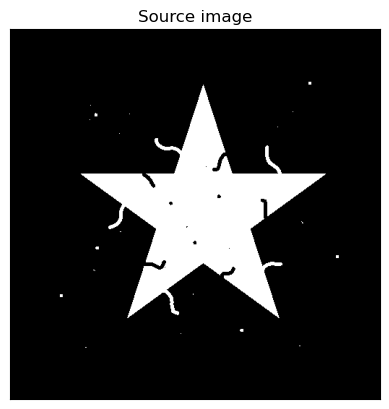

In [31]:
# Read a binary image from file in grayscale
fn1 = "images/star.png"
I1 = cv.imread(fn1, cv.IMREAD_GRAYSCALE)
if not isinstance(I1, np.ndarray) or I1.data == None:
  print("Error reading file \"{}\"".format(fn1))
else:
  # Threshold it
  ret, I1 = cv.threshold(I1, 127, 255, cv.THRESH_BINARY_INV)
  # Display it
  ShowImages([("Source image", I1)])

### 1.3 Morphological operations

Before trying to clean up an image, we will try running considered morphological operations on it.

#### 1.3.1 Structuring element

The first thing we need to to is create a structuring element. Let's create different default types of elements and display them to have a look.

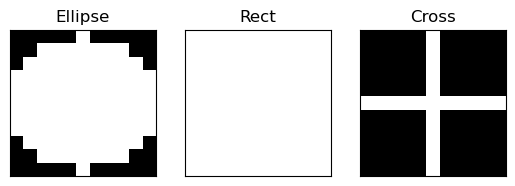

ellipse_element = 
[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]]


In [32]:
# Create an 11 x 11 pixels elliptical structuring element (filled circle)
ellipse_element = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
# Create an 11 x 11 pixels rectangular structuring element
rect_element = cv.getStructuringElement(cv.MORPH_RECT, (11, 11))
# Create an 11 x 11 pixels cross shape structuring element
cross_element = cv.getStructuringElement(cv.MORPH_CROSS, (11, 11))

# And display them
ShowImages([("Ellipse", ellipse_element), 
            ("Rect", rect_element), 
            ("Cross", cross_element)], 3, vmin = 0, vmax = 1)

# Let's also print one of them to see the contents
print("ellipse_element = ")
print(ellipse_element)

As you see, the structuring element is a binary matrix with `1` meaning that this pixel is used in morphological operations and `0` meaning that pixel is omitted. So, this is very similar to kernels which were used during 2D filters and we can create own elements if needed.

During this assignment we will use the elliptical structuring element, however you may try using the different one and compare the results.

In [33]:
# Shorten the element name
element = ellipse_element

#### 1.3.2 Erode operation

The first operation we will try is an erode operation. It erodes the binary image narrowing the shape. Let's run it several times and check how it affect the object morphology.

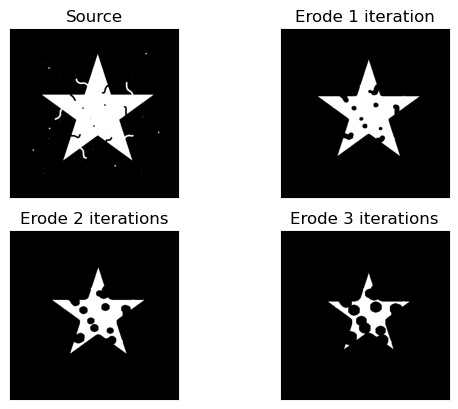

In [34]:
# Try the erode operation
I1erode1 = cv.morphologyEx(I1, cv.MORPH_ERODE, element, iterations = 1)
I1erode2 = cv.morphologyEx(I1, cv.MORPH_ERODE, element, iterations = 2)
I1erode3 = cv.morphologyEx(I1, cv.MORPH_ERODE, element, iterations = 3)
ShowImages([("Source", I1),
            ("Erode 1 iteration", I1erode1),
            ("Erode 2 iterations", I1erode2),
            ("Erode 3 iterations", I1erode3)], 2)

As you can see, eroding a morphology decreases it's side and completely removes small external areas, however internal holes got bigger.

#### 1.3.3 Dilation operation

Opposite to erosion, dilation operation grows and object. Let's run it several times and check how it affect the object morphology.

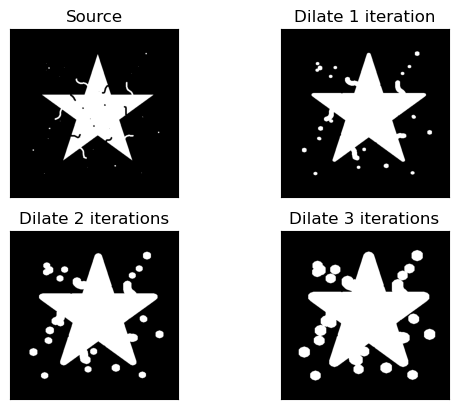

In [35]:
# Try the dilate operation
Idilate1 = cv.morphologyEx(I1, cv.MORPH_DILATE, element, iterations = 1)
Idilate2 = cv.morphologyEx(I1, cv.MORPH_DILATE, element, iterations = 2)
Idilate3 = cv.morphologyEx(I1, cv.MORPH_DILATE, element, iterations = 3)
ShowImages([("Source", I1),
            ("Dilate 1 iteration", Idilate1),
            ("Dilate 2 iterations", Idilate2),
            ("Dilate 3 iterations", Idilate3)], 2)

As you can see, now all internal holes are filled, the object increased its size, however all outside noise also got much more noticeable.

#### 1.3.4 Open operation

The open operation is a dilation of an erosion of the object morphology. It should allow removing the external object morphology defects while keeping the general shape and shape size almost untouched. Let's run it several times and check how it affect the object morphology.

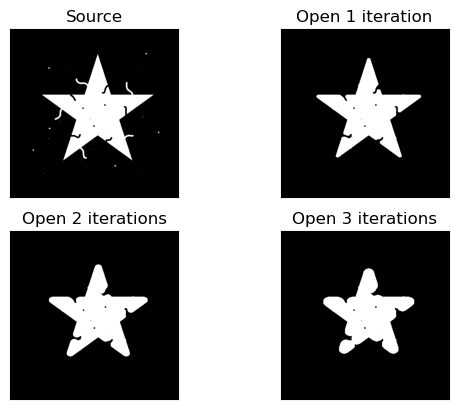

In [36]:
# Try the open operation
I1open1 = cv.morphologyEx(I1, cv.MORPH_OPEN, element, iterations = 1)
I1open2 = cv.morphologyEx(I1, cv.MORPH_OPEN, element, iterations = 2)
I1open3 = cv.morphologyEx(I1, cv.MORPH_OPEN, element, iterations = 3)
ShowImages([("Source", I1),
            ("Open 1 iteration", I1open1),
            ("Open 2 iterations", I1open2),
            ("Open 3 iterations", I1open3)], 2)

You can see that now most of the external defects are removed while internal ones are more or less as they were before.

#### 1.3.5 Close operation

The close operation is an erosion of a dilation of the object morphology. It should allow removing the internal object morphology defects while keeping the general shape and shape size almost untouched. Let's run it several times and check how it affect the object morphology.

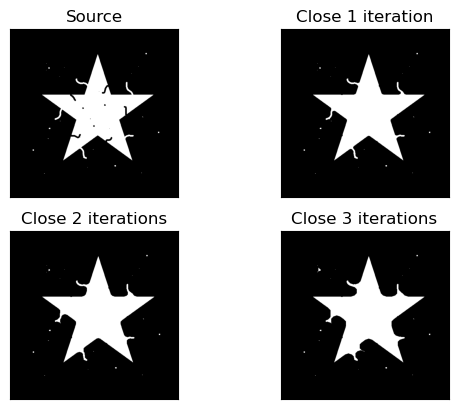

In [37]:
# Try the close operation
I1close1 = cv.morphologyEx(I1, cv.MORPH_CLOSE, element, iterations = 1)
I1close2 = cv.morphologyEx(I1, cv.MORPH_CLOSE, element, iterations = 2)
I1close3 = cv.morphologyEx(I1, cv.MORPH_CLOSE, element, iterations = 3)
ShowImages([("Source", I1),
            ("Close 1 iteration", I1close1),
            ("Close 2 iterations", I1close2),
            ("Close 3 iterations", I1close3)], 2)

You can see that now most of internal defects are removed while the external ones are more or less as they were before.

#### 1.3.6 Contours

With morphology it's easy to extract the object contours. We can get either internal or external contour of an object:
 - To get an internal contour of an object, we have to subtract the object erosion result from the object itself;
 - To get an external contour of an object, we have to subtract the object from its dilation result.

 The width of the contour is defined by the structuring element. To check these methods, we will create a smaller structuring element with size $3 \times 3$.

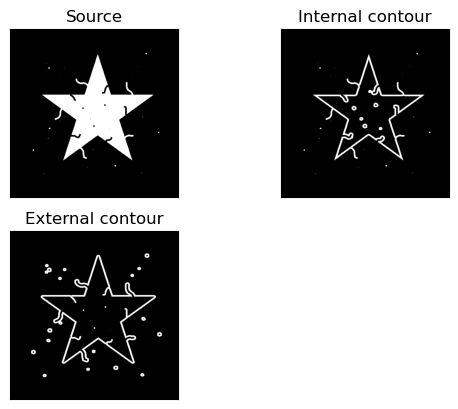

In [38]:
# Create a 3 x 3 elliptical structuring element
element3x3 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
I1internal = I1 - cv.morphologyEx(I1, cv.MORPH_ERODE, element, iterations = 1)
I1external = cv.morphologyEx(I1, cv.MORPH_DILATE, element, iterations = 1) - I1
ShowImages([("Source", I1), 
            ("Internal contour", I1internal), 
            ("External contour", I1external)], 2)

#### 1.3.7 "bwareaopen" from MATLAB operation

MATLAB provides a very useful operation named `bwareaopen()` which works with morphology, however OpenCV doesn't have it. This operation searches for all areas of size less than the given one and opens them. This operation is very handy when working with morphology as it allows to remove all small areas from morphology, so let's implement. Let's implement it.

The implementation is very similar and straightforward:
1. Use the `cv2.connectedComponentsWithStats()` function to search for all connected components of the image with given connectivity.
2. Loop through components and fill the areas with size less than given.

In [39]:
# Remove small objects from binary image
# @param[in] I Image
# @param[in] dim A minium size of an area to keep
# @param[int] connectivity Pixel connectivity
# @return An image with components less then dim in size removed
def bwareaopen(I : np.ndarray, dim : int, connectivity : int = 8):
  # We work with single layer images only
  if I.ndim > 2:
    return None
  Iout = I.copy()

  # Find all connected components
  num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(Iout, connectivity = connectivity)

  # Check size of all connected components
  for i in range(num_labels):
    # Remove connected components smaller than dim
    if stats[i, cv.CC_STAT_AREA] < dim:
      Iout[labels == i] = 0

  return Iout

Try running it with our source image and open all areas with size less than $30$.

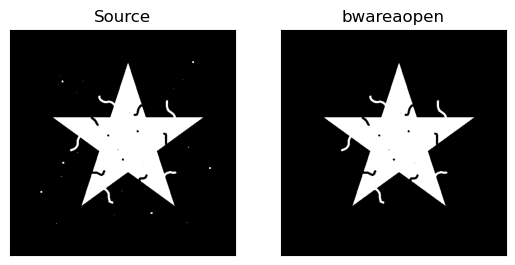

In [40]:
# Remove all areas with area size less than 30  
I1bwao = bwareaopen(I1, 30)
ShowImages([("Source", I1),
            ("bwareaopen", I1bwao)], 2)

As you see, all external shapes with area size less than $30$ were removed. However we can use this function to remove internal holes too. To do this we have to invert the morphology, call the `bwreaopen()` function and invert the result. Let's remove all holes with size less than $25$ from our morphology object.

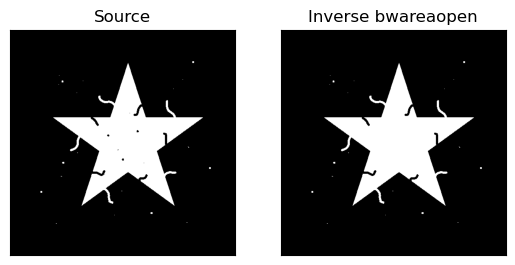

In [41]:
# Remove all areas with holes size less than 25 
I1ibwao = ~bwareaopen(~I1, 25)
ShowImages([("Source", I1),
            ("Inverse bwareaopen", I1ibwao)], 2)

If we want to remove both small external objects and internal holes, then we need to combine these two operations.

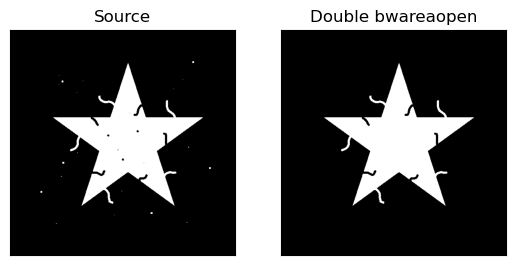

In [42]:
# Remove all areas with area size less than 30 and holes with size less than 25 
I1ibwao = ~bwareaopen(~bwareaopen(I1, 30), 25)
ShowImages([("Source", I1),
            ("Double bwareaopen", I1ibwao)], 2)

### 1.4 Cleaning up an image

Now we learned some basic morphological operations and can clean this image. So, what we know now:
1. We can remove all external small areas by using the `bwareaopen()` function;
2. We can remove all internal holes by using the inverse of the `bwareaopen()` function;
3. We can clean the internal defects by using the $close$ operation;
4. We can clean the external defects by using the $open$ operation.

Let's use these operation parameters and adjust their parameters to clean up our source image. We will use the small structuring element and run several iterations of morphological operations to reduce the affection of the general morphology shape.

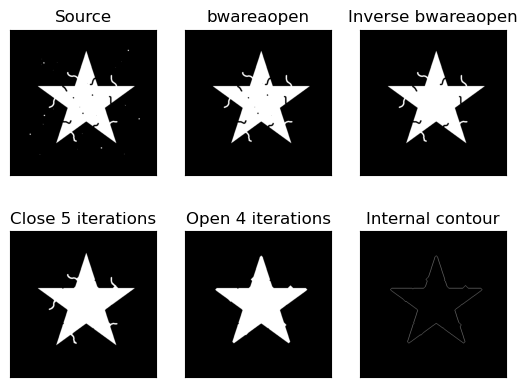

In [43]:
# First we use bwareaopen and open all external small areas
I1clean1 = bwareaopen(I1, 20)
# Next we clean up holes
I1clean2 = ~bwareaopen(~I1clean1, 25)
# First we need to adjust the structuring element shape and size
element3x3 = cv2.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
# Remove all internal defects with close operation
I1clean3 = cv.morphologyEx(I1clean2, cv.MORPH_CLOSE, element3x3, iterations = 5)
# And remove the external defects by running open operation
I1clean4 = cv.morphologyEx(I1clean3, cv.MORPH_OPEN, element3x3, iterations = 5)
# Finally, let's calculate the internal contour of an object
I1clean5 = I1clean4 - cv.morphologyEx(I1clean4, cv.MORPH_ERODE, element3x3, iterations = 1)

ShowImages([("Source", I1),
            ("bwareaopen", I1clean1), 
            ("Inverse bwareaopen", I1clean2), 
            ("Close 5 iterations", I1clean3),
            ("Open 4 iterations", I1clean4),
            ("Internal contour", I1clean5)], 3)

### 1.5 Self-work

---
> ***Self-work***
>
> Select an arbitrary image containing shape defects (internal "holes" and external "ledges"). Use the basic morphological operations to completely remove or minimize these defects.
---

In [44]:
# TODO Place your solution here
I2own = None

## Task 2. Objects splitting

*Select an arbitrary binary image containing overlapping objects. Use binary morphology operations to separate objects.*

One of the examples of using morphological operations on an image is the problem of on an image separating objects glued together. The problem can be solved with a sufficient degree of accuracy by sequentially executing the erosion filter several times, and then dilate the result. Intersection of the original image with the processed one will separate the glued objects.

### 2.1 Example

Let's try implementing this algorithm.

#### 2.1.1 Read and preprocess an image

First of all we need some input image. It's not so interesting to start working with morphology directly, so we will take some image with objects, threshold it to get a binary image, clean it up and use this cleaned up morphology as a starting point. For this we will use an image with some coins on a white table. 

Now we have get a morphology from it. For this we will first convert it to grayscale and threshold the grayscale image.

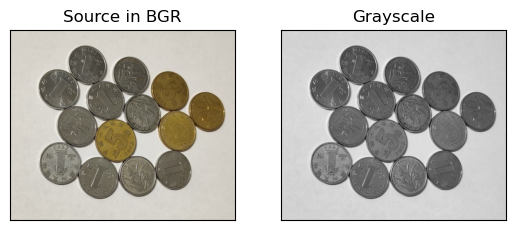

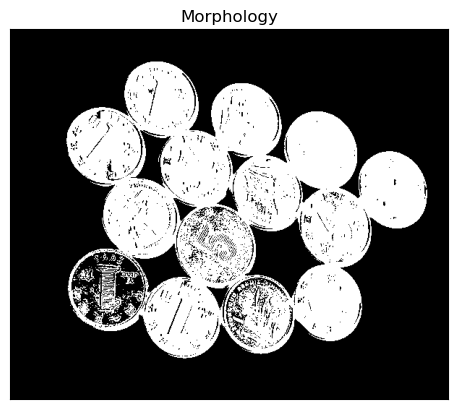

In [45]:
# Read a binary image from file in grayscale
fn2 = "images/coins.jpg"
I2 = cv.imread(fn2, cv.IMREAD_COLOR)
if not isinstance(I2, np.ndarray) or I2.data == None:
  print("Error reading file \"{}\"".format(fn2))
else:
  # Convert it to gayscale
  I2gray = cv.cvtColor(I2, cv.COLOR_BGR2GRAY)
  # Threshold it
  ret, I2bw = cv.threshold(I2gray, 127, 255, cv.THRESH_BINARY_INV)
  # Display these three images
  ShowImages([("Source in BGR", I2),
              ("Grayscale", I2gray)], 2)
  ShowImages([("Morphology", I2bw)], 2)

As you see, the initial morphology to work with is not good with default settings. So we should adjust the thresholding parameters. However in this case we can use another thresholding method which is called Otsu thresholding and invert its result

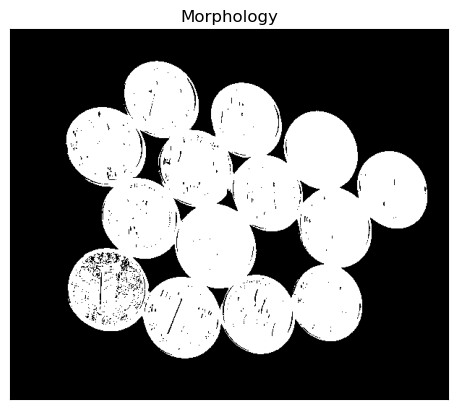

In [46]:
# Threshold an image
ret, I2m = cv.threshold(I2gray, 127, 255, cv.THRESH_OTSU)
I2m = ~I2m
ShowImages([("Morphology", I2m)], 2)

#### 2.1.2 Clean up the image

Now we got a morphology we can work with. Let's clean it, we know how to do it already. Most of defects can be cleaned by inverse bwareaopen operations. Other can be cleaned by applying the closing operation.

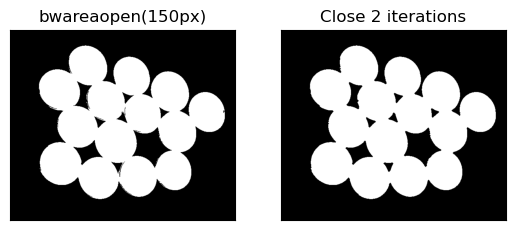

In [47]:
# Fill holes
I2clean1 = ~bwareaopen(~I2m, 150)
# Create structuring element
element3x3 = cv2.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
# Close several times to finish cleaning
I2clean2 = cv.morphologyEx(I2clean1, cv.MORPH_CLOSE, element3x3, iterations = 2)
ShowImages([("bwareaopen(150px)", I2clean1), 
            ("Close 2 iterations", I2clean2)], 2)
I2clean = I2clean2

#### 2.1.3 Split objects with erosion

Now we got a clean morphology, but it still has several objects glued together, so we have to separate them. Let's erode it several times with $7 \times 7$ element. This will give us small separate objects in the centers of objects we are searching for. If we invert the result we will get a shape of the border between objects.

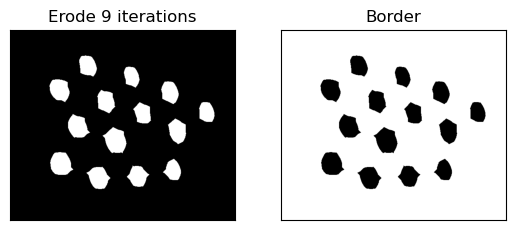

In [48]:
# Create structuring element
element7x7 = cv2.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
I2centers = cv.morphologyEx(I2clean, cv.MORPH_ERODE, element7x7, iterations = 9, borderType = cv.BORDER_CONSTANT, borderValue = (0))
I2border = ~I2centers
ShowImages([("Erode 9 iterations", I2centers),
            ("Border", I2border)], 2)


#### 2.1.4 Find borders

As you see, we can't use these borders directly, we have to thicken them. For this need we will use the following algorithm:
 1. Erode the image;
 2. Open the erosion result;
 3. Subtract the erosion result from opening of the erosion;
 4. Add the subtraction result to a thickened borders accumulated;
 5. If there are still any non-zero pixels in the image *go to sep 1*.

 The main idea of this algorithm is that after each erosion we check if the line disappeared in some point by comparing it with opening result. If yes, then we add these pixels to the thickened border. We can adjust this algorithm by using different structuring elements at erosion and opening operations.

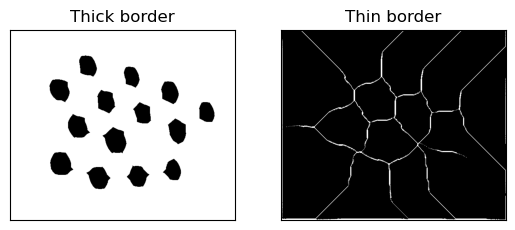

In [49]:
element3x3 = cv2.getStructuringElement(cv.MORPH_RECT, (3, 3))
element5x5 = cv2.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
I2tmp = I2border.copy()
I2border2 = np.zeros_like(I2tmp)
while cv.countNonZero(I2tmp) > 0:
  # Dilate
  I2tmp_erode = cv.erode(I2tmp, element3x3, borderType = cv.BORDER_CONSTANT, borderValue = (255))
  # Closing on dilated image
  I2tmp_open = cv.morphologyEx(I2tmp_erode, cv.MORPH_OPEN, element5x5, borderType = cv.BORDER_CONSTANT, borderValue = (0))
  # Subtract them as masks
  subset = cv.bitwise_and(~I2tmp_open, I2tmp_erode)
  # Unite subtraction results with all previous sets
  I2border2 = cv.bitwise_or(subset, I2border2)
  # Continue working with dilated image at next iteration
  I2tmp = I2tmp_erode
# The border is a result of the binary operations, so hold 0 or 1 values
# We multiply it by 255 to get into image range
ShowImages([("Thick border", I2border), ("Thin border", I2border2)], 2)

#### 2.1.5 Process the result

Now we have thin borders and we can subtract these borders from out morphology and split objects.

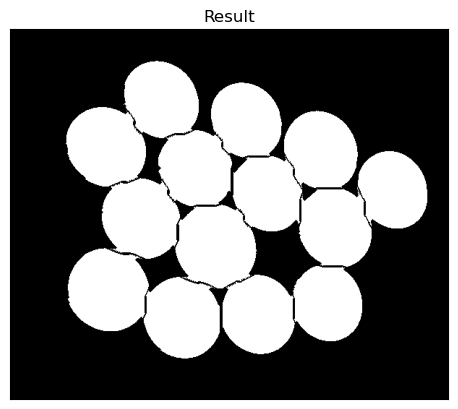

In [50]:
I2m_split = cv.bitwise_and(I2clean, ~I2border2)
ShowImages([("Result", I2m_split)], vmin = 0, vmax = 255)

Now we can apply this mask to our source image and get split objects.

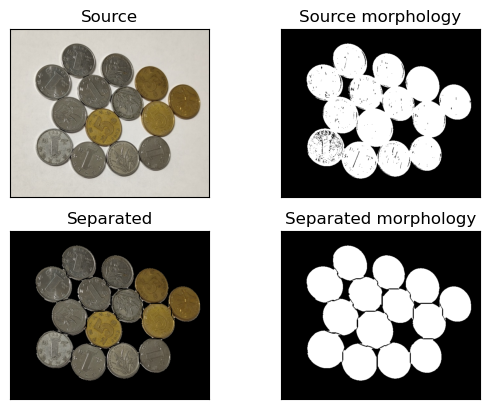

In [51]:
I2split = I2.copy()
I2split[I2m_split < 128] = 0
ShowImages([("Source", I2), 
            ("Source morphology", I2m),
            ("Separated", I2split), 
            ("Separated morphology", I2m_split)], 2)

As you can see this method result is not perfect, so we will use another one to get better object separation results.

### 2.2 Self-work

---
> ***Self-work***
>
> Select an arbitrary binary image containing overlapping objects. Use binary morphology operations to separate objects.
>
> You may start with object morphology image and do steps 2.1.3 - 2.1.5 only.
>
> *Optional: start with objects image and do all steps.*
---

In [52]:
# TODO Place your solution here
I2own = None

## Task 3. Morphological watershed segmentation

*Select an arbitrary image containing a small number of local minima. Perform image segmentation by watershed approach.*

Let us consider one more example of the mathematical morphology application to the image segmentation problem. In the watershed segmentation approach, an image is viewed as a height map, in which pixel intensities describe heights relative to a certain level. On such a "altitude area" is "pouring rain", forming a multitude of *drainage basins*. Water in overflowing basins merge basins into larger ones (see the figure below).

| ![Watershed areas](images/watershed.png "Watershed areas") | 
|:--:| 
| *Watershed areas.* |


Basin junctions are marked as watershed lines. If the "rain" is stopped early, then the image will be segmented into small areas, and if it is late then into large ones. In this approach, all pixels are divided into three types:
 - *local minima*;
 - *on the slope* (from which the water rolls down to the same local minimum);
 - *local maxima* (from which the water rolls down to more than one minimum).

 When implementing this method, it is necessary to determine the catchment basins and watershed lines by processing local areas and calculating their characteristics. The segmentation algorithm consists of the following steps:
 1. Segmentation function calculation. Typically, a image gradient representation is used for this.
 2. Foreground markers calculation. Typically, it is based on the pixel connectivity of each object.
 3. Background marker calculation. This marker represents non-object pixels.
 4. Segmentation function execution, taking into account the relative position of the foreground and background markers.

As a algorithm result, a mask will be obtained, where the same segments pixels will be marked with the same markers and will form connected areas.

### 3.1 Example

Let's implement this algorithm step by step.

#### 3.1.1 Read and preprocess an image

We already know how to do it, so let's read an image.

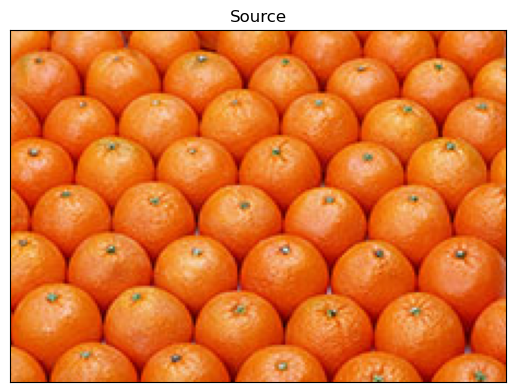

In [53]:
fn3 = "images/oranges.jpg"

# Read an image from file
I3 = cv.imread(fn3, cv.IMREAD_COLOR)
if not isinstance(I3, np.ndarray) or I3.data == None:
  print("Error reading file \"{}\"".format(fn3))
else:
  # Show images
  ShowImages([("Source", I3)])

Convert it to grayscale and get base morphology from it by thresholding. Since background is darker, we have to do thresholding with inverting the result (controlled by the `invert` flag which sets `cv.THRESH_BINARY_INV` thresholding parameter).

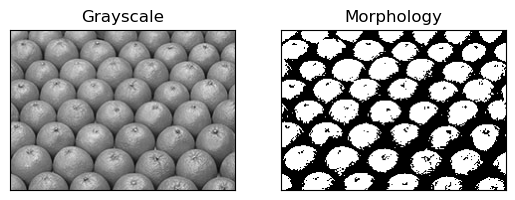

In [54]:
# Convert to grayscale and then to BW
I3gray = cv.cvtColor(I3, cv.COLOR_BGR2GRAY)
invert = False
if invert:
  ret, I3bw = cv.threshold(I3gray, 160, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
else:
  ret, I3bw = cv.threshold(I3gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Show images
ShowImages([("Grayscale", I3gray),
            ("Morphology", I3bw)], 2)

#### 3.1.2 Clean up the morphology

Now we have to clean this morphology a little to detect object centers.

#### 3.1.3 Getting foreground markers

To find area with foreground markers we can use the Euclidean distance transformation that calculates the distance to the closest zero pixel for each pixel of the image. This transformation is executed by calling OpenCV\`s `cv2.distanceTransform()` function. Then we will threshold it to find each area center marker.


In [55]:
I3dist = cv.distanceTransform(I3bw_clean, cv.DIST_L2, 5)
ret, I3fg = cv.threshold(I3dist, 0.6 * I3dist.max(), 255, 0)
I3fg = (I3fg.astype(np.float32) / I3fg.max() * 255).astype(np.uint8)
ShowImages([("Distance", I3dist.astype(np.float32) / I3dist.max()),
            ("Foreground", I3fg)], 2)

NameError: name 'I3bw_clean' is not defined

Now we have all the data required to define foreground markers for the watershed algorithm. To define foreground markers we have to set area index for each marker pixel, this can be done with help of the `cv2.connectedComponents()` function. This function will find all connected components locations which are exactly our marker positions.

To visualize markers with different colors we will use the JET coloring scheme which can be applied to our markers by `cv2.applyColorMap()` function with `cv2.COLORMAP_JET` parameter.

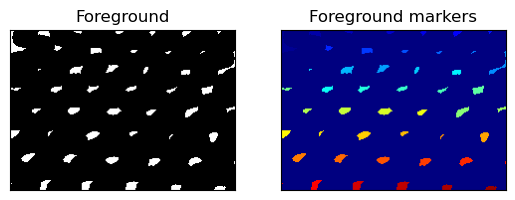

In [29]:
n_markers, I3markers_fg = cv.connectedComponents(I3fg)
ShowImages([("Foreground", I3fg),
            ("Foreground markers", 
             cv.applyColorMap((I3markers_fg.astype(np.float32) * 255 / n_markers).astype(np.uint8), 
                              cv.COLORMAP_JET))], 2)

#### 3.1.4 Getting background marker

Next, we have to find a background area marker. It can be found by executing the watershed algorithm on the foreground markers data and selecting the resulting areas boundary area as a background area. This solution works well if objects are placed tightly and background area is hard to mark.

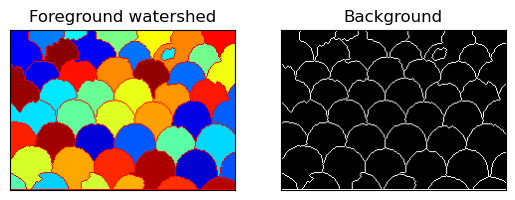

In [30]:
# Create a temporary markers array for executing the watershed algorithm
I3markers = I3markers_fg.copy()
I3markers = cv.watershed(I3, I3markers)
# The border area is indexed as -1 in resulting markers
I3markers_bg = np.zeros_like(I3markers_fg)
I3markers_bg[I3markers == -1] = 255
# Show the result of foreground watershed and the background marker
ShowImages([("Foreground watershed", 
             cv.applyColorMap((I3markers.astype(np.float32) * 255 / ret).astype(np.uint8), 
                              cv.COLORMAP_JET)),
            ("Background", I3markers_bg)], 2)

#### 3.1.5 Define the watershed parameters

Now we have information about foreground and background markers positions. Everything which is not foreground or background is undefined and is subject to be filled with watershed algorithm.
 - We can find the undefined area as everything except for foreground or background markers.
 - Background marker can be merged into foreground by adding one more marker to with number next to the maximum one.

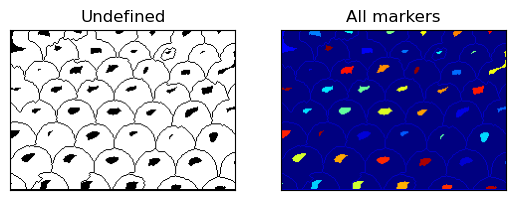

In [31]:
# Undefined area (what to fill with watershed)
I3und = ~np.bitwise_or(I3markers_bg > 0, I3markers_fg > 0)

# Background marker is 0, let's make it 1 to define new unknown region
I3markers = I3markers_fg.copy()
# Now, mark the region of unknown with zero
I3markers[I3markers_bg == 255] = I3markers.max() + 1
ShowImages([("Undefined", I3und),
           ("All markers", 
            cv.applyColorMap((I3markers.astype(np.float32) * 255 / ret).astype(np.uint8), 
                             cv.COLORMAP_JET))], 2)


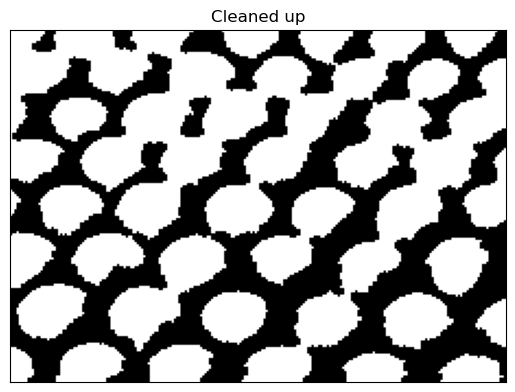

In [34]:
I3bw_clean = ~bwareaopen(~I3bw, 20, 4)
I3bw_clean = bwareaopen(I3bw_clean, 20, 4)
element5x5 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
I3bw_clean = cv.morphologyEx(I3bw_clean, cv.MORPH_CLOSE, element5x5, iterations = 1)
ShowImages([("Cleaned up", I3bw_clean)], 1)

#### 3.1.6 Run watershed algorithm and process the results

Now we have all markers set and are ready to run the watershed algorithm by calling the `cv2.watershed()` function.

In [35]:
I3markers = cv.watershed(I3, I3markers)

The `I3markers` matrix now holds the segmentation result. Each pixel is now assigned to some segment and boundary has index $-1$. We may use it to highlight the object boundaries with green color.

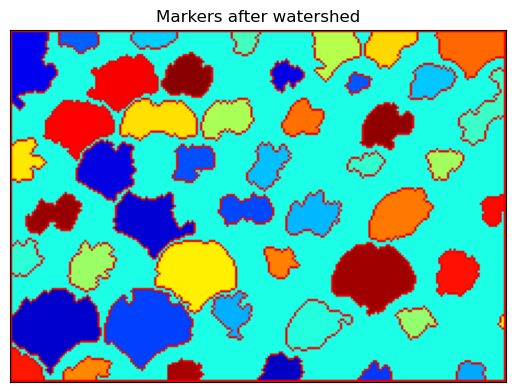

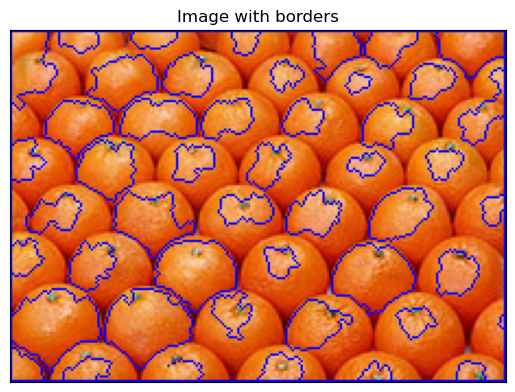

In [36]:
I3result = I3.copy()
# Change color of border pixels
I3result[I3markers == -1] = (255, 0, 0)
ShowImages([("Markers after watershed", 
             cv.applyColorMap((I3markers.astype(np.float32) * 255 / (ret + 1)).astype(np.uint8), 
                              cv.COLORMAP_JET)),
            ("Image with borders", I3result)])

As you see, due to a very thin border, the segmentation result is not perfect and border got significantly thicker due to specifics of the algorithm used.

### 3.2 Another approach for background marker

Another approach to find a background area marker can be by sequential dilation of the filtered black and white image. The inversion of dilation result should give us an area that is sure to be a background and can act as a background marker. This solution works well in case if background area is rather big and would not become empty after dilation operation.

Let's try this approach on the coins images we saw in the **Task 2** and stored in `I2` image with morphology in `I2clean`.

**Foreground marker**

First we will repeat same steps to get foreground markers.

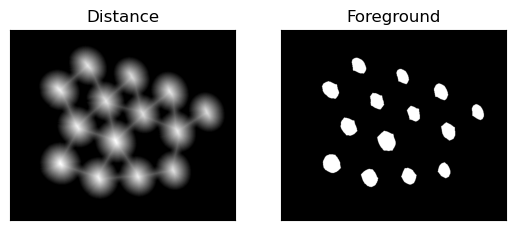

In [37]:
# Foreground markers
I2dist = cv.distanceTransform(I2clean, cv.DIST_L2, 5)
ret, I2fg = cv.threshold(I2dist, 0.6 * I2dist.max(), 255, 0)
I2fg = (I2fg.astype(np.float32) / I2fg.max() * 255).astype(np.uint8)
ShowImages([("Distance", I2dist.astype(np.float32) / I2dist.max()),
            ("Foreground", I2fg)], 2)

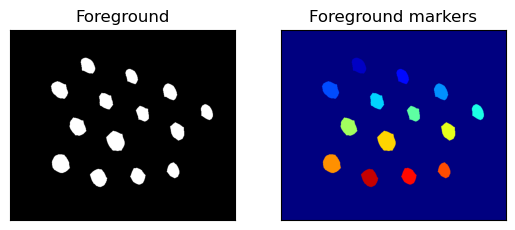

In [46]:
n_markers, I2markers_fg = cv.connectedComponents(I2fg)
ShowImages([("Foreground", I2fg),
            ("Foreground markers", 
             cv.applyColorMap((I2markers_fg.astype(np.float32) * 255 / n_markers).astype(np.uint8), 
                              cv.COLORMAP_JET))], 2)

**Background marker**

Background area can be defined by inverse of dilation of the initial morphology.

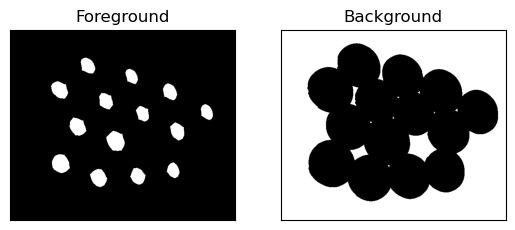

In [47]:
element7x7 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
I2markers_bg = ~cv.morphologyEx(I2clean, cv.MORPH_DILATE, element7x7, iterations = 2)
ShowImages([("Foreground", I2fg),
            ("Background", I2markers_bg)], 2)

**Define parameters**

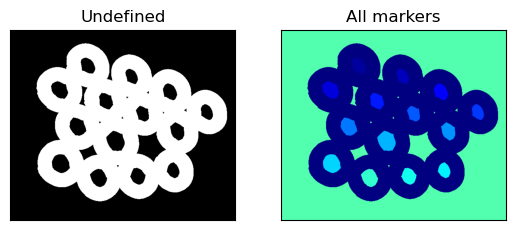

In [48]:
# Undefined area (what to fill with watershed)
I2und = ~np.bitwise_or(I2markers_bg > 0, I2markers_fg > 0)

# Background marker is 0, let's make it 1 to define new unknown region
I2markers = I2markers_fg.copy()
# Now, mark the region of unknown with zero
I2markers[I2markers_bg == 255] = I2markers.max() + 1
ShowImages([("Undefined", I2und),
           ("All markers", 
            cv.applyColorMap((I2markers.astype(np.float32) * 255 / ret).astype(np.uint8), 
                             cv.COLORMAP_JET))], 2)


**Run watershed algorithm and process the results**

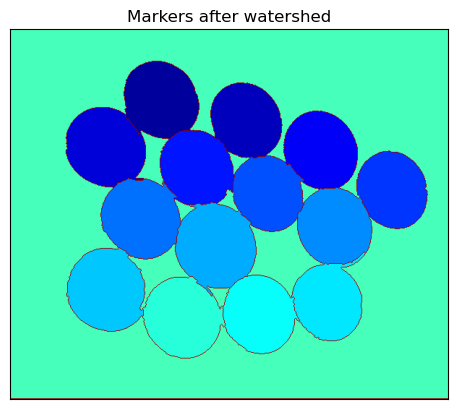

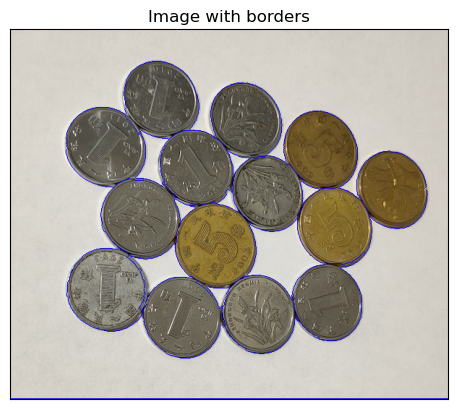

In [49]:
# Run watershed
I2markers = cv.watershed(I2, I2markers)
I2result = I2.copy()
# Change color of border pixels
I2result[I2markers == -1] = (255, 0, 0)
ShowImages([("Markers after watershed", 
             cv.applyColorMap((I2markers.astype(np.float32) * 255 / (ret + 1)).astype(np.uint8), 
                              cv.COLORMAP_JET)),
            ("Image with borders", I2result)])

### 3.3 Self-work

---
> ***Self-work***
>
> Select an arbitrary image containing a small number of local minima. Perform image segmentation by watershed approach.
---

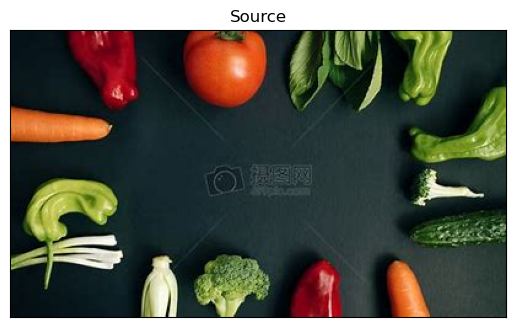

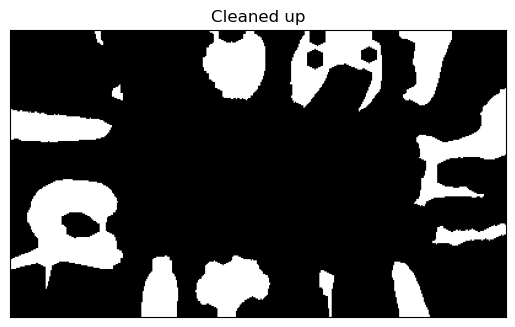

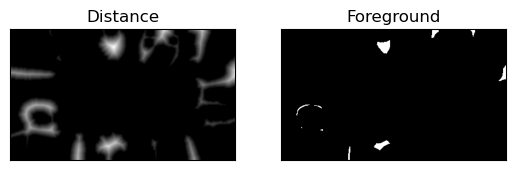

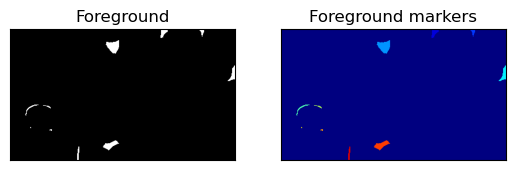

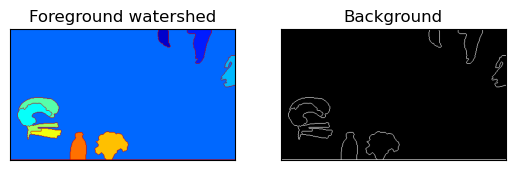

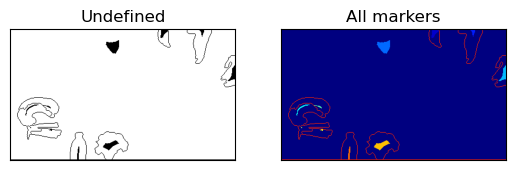

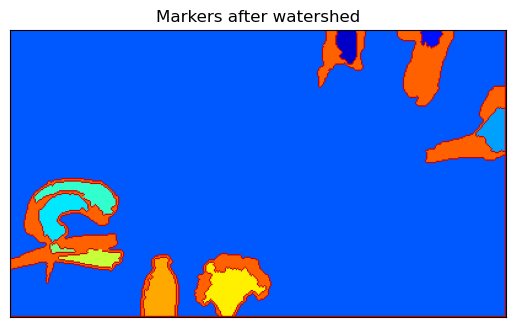

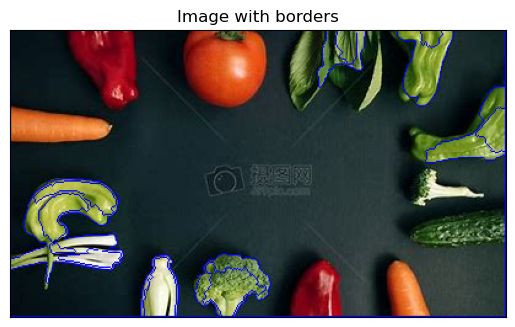

In [66]:
# TODO Place your solution here
I3own = None

import cv2 as cv
import numpy as np

fn = "D:\study_homework\image processing\images\OIP (4).jpg"

I = cv.imread(fn, cv.IMREAD_COLOR)
if not isinstance(I, np.ndarray) or I.data is None:
    print("Error reading file \"{}\"".format(fn))
else:
    ShowImages([("Source", I)])

Igray = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
ret, Ibw = cv.threshold(Igray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

Ibw_clean = ~bwareaopen(~Ibw, 15, 8)
Ibw_clean = bwareaopen(Ibw_clean, 15, 8)
element5x5 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
Ibw_clean = cv.morphologyEx(Ibw_clean, cv.MORPH_CLOSE, element5x5, iterations=3)
ShowImages([("Cleaned up", Ibw_clean)], 1)

Idist = cv.distanceTransform(Ibw_clean, cv.DIST_L2, 5)
ret, Ifg = cv.threshold(Idist, 0.6 * Idist.max(), 255, 0)
Ifg = (Ifg.astype(np.float32) / Ifg.max() * 255).astype(np.uint8)
ShowImages([("Distance", Idist.astype(np.float32) / Idist.max()),
            ("Foreground", Ifg)], 2)

n_markers, Imarkers_fg = cv.connectedComponents(Ifg)
ShowImages([("Foreground", Ifg),
            ("Foreground markers",
             cv.applyColorMap((Imarkers_fg.astype(np.float32) * 255 / n_markers).astype(np.uint8),
                              cv.COLORMAP_JET))], 2)

Imarkers = Imarkers_fg.copy()
Imarkers = cv.watershed(I, Imarkers)
Imarkers_bg = np.zeros_like(Imarkers_fg)
Imarkers_bg[Imarkers == -1] = 255
ShowImages([("Foreground watershed",
             cv.applyColorMap((Imarkers.astype(np.float32) * 255 / ret).astype(np.uint8),
                              cv.COLORMAP_JET)),
            ("Background", Imarkers_bg)], 2)

Iund = ~np.bitwise_or(Imarkers_bg > 0, Imarkers_fg > 0)

Imarkers = Imarkers_fg.copy()
Imarkers[Imarkers_bg == 255] = Imarkers.max() + 1
ShowImages([("Undefined", Iund),
            ("All markers",
             cv.applyColorMap((Imarkers.astype(np.float32) * 255 / ret).astype(np.uint8),
                              cv.COLORMAP_JET))], 2)

Imarkers = cv.watershed(I, Imarkers)

Iresult = I.copy()
Iresult[Imarkers == -1] = (255, 0, 0)
ShowImages([("Markers after watershed",
             cv.applyColorMap((Imarkers.astype(np.float32) * 255 / (ret + 1)).astype(np.uint8),
                              cv.COLORMAP_JET)),
            ("Image with borders", Iresult)])


---
> ***Self-work***
>
> Answer questions and conclude your work results.
---

 ## Questions

Please answer the following questions:

 - Does the opening result include the closing result?
 > Put your answer here
 
 - What morphological filter should be applied to remove ledges from an object?
 > Put your answer here
 
 - How can you find the object edges using morphological operations?
 > Put your answer here
 
 - What is morphology?
 > Put your answer here
 


## Conclusion

What have you learned with this task? Don't forget to conclude it.
 > Put your conclusion here
